<a href="https://colab.research.google.com/github/Abhishek92kumar/LJMU/blob/main/Layout_Parser_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Layout Parser Model Training**

# Detectron2

Detectron2 is Facebook AI Research's next generation software system that implements state-of-the-art object detection algorithms. It is a ground-up rewrite of the previous version, Detectron, and it originates from maskrcnn-benchmark

### Installation
* detectron2 is not pre-installed in this kaggle docker, so let's install it.
* we need to know CUDA and pytorch version to install correct detectron2.

In [1]:
!nvidia-smi

Tue Jun  6 19:47:56 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


In [3]:
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())

2.0.1+cu118 True


* It seems CUDA=11.0 and torch==1.7.0 is used in this kaggle docker image.
* See installation for details. https://detectron2.readthedocs.io/en/latest/tutorials/install.html

### Install Pre-Built Detectron2

In [4]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.4#egg=detectron2' 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.4) to /tmp/pip-install-j1hm6u88/detectron2_512f213f80664c92ab440b104ba98dc1
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-install-j1hm6u88/detectron2_512f213f80664c92ab440b104ba98dc1
  Running command git checkout -q 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Resolved https://github.com/facebookresearch/detectron2.git to commit 4aca4bdaa9ad48b8e91d7520e0d0815bb8ca0fb1
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.5/47.5 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━

# importing libraries

In [5]:
import pandas as pd
import numpy as np
import pandas as pd 
from tqdm import tqdm
from tqdm import tqdm_notebook as tqdm # progress bar
from datetime import datetime
import time
import matplotlib.pyplot as plt
#from pycocotools.coco import COCO
import os, json, cv2, random
import skimage.io as io
import copy
from pathlib import Path
from typing import Optional


# torch
import torch

# Albumenatations
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

#from pycocotools.coco import COCO
from sklearn.model_selection import StratifiedKFold

# glob
from glob import glob

# numba
import numba
from numba import jit

import warnings
warnings.filterwarnings('ignore') #Ignore "future" warnings and Data-Frame-Slicing warnings.


# detectron2
from detectron2.structures import BoxMode
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.engine import DefaultPredictor, DefaultTrainer, launch
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import BoxMode
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import Visualizer

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils


from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader, build_detection_train_loader
from detectron2.data import detection_utils as utils
import detectron2.data.transforms as T
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

setup_logger()

<Logger detectron2 (DEBUG)>

In [6]:
# importing prerequisites
import sys
import requests
import tarfile
import json
import numpy as np
from os import path
from PIL import Image
from PIL import ImageFont, ImageDraw
from glob import glob
from matplotlib import pyplot as plt
%matplotlib inline

In [7]:
fname = 'examples.tar.gz'
url = 'https://dax-cdn.cdn.appdomain.cloud/dax-publaynet/1.0.0/' + fname
r = requests.get(url)
open(fname , 'wb').write(r.content)
# Extracting the dataset
tar = tarfile.open(fname)
tar.extractall()
tar.close()
# Verifying the file was extracted properly
data_path = "examples"
path.exists(data_path)

False

In [8]:
# f = open('/content/publaynet/samples.json',)

f = open('/content/examples/samples.json',)
thing_classes  = []
thing_classes_id = {}
data_annotations=[]
data = json.load(f)
#----Images----
data_images=data['images']
#---annotations-
for i in data['annotations']:
    annot_obj ={"id": i['id'],"image_id": i['image_id'],"category_id":i['category_id'],
          "x_min":i['bbox'][0], #left
          "y_min":i['bbox'][1], #top
          "x_max":i['bbox'][0]+i['bbox'][2], #left+width
          "y_max":i['bbox'][1]+i['bbox'][3] #top+hieght
         }
    data_annotations.append(annot_obj) 
#---categories-
for i in data['categories']:
    thing_classes.append(i['name'])
    thing_classes_id[i['name']]=i['id']
f.close()
print("thing_classes=",thing_classes)
print("thing_classes_id=",thing_classes_id)

thing_classes= ['text', 'title', 'list', 'table', 'figure']
thing_classes_id= {'text': 1, 'title': 2, 'list': 3, 'table': 4, 'figure': 5}


In [9]:
thing_classes= ['None','text', 'title', 'list', 'table', 'figure']

In [10]:
train_meta = pd.DataFrame(data_images)
train_meta = train_meta[['id', 'file_name', 'width', 'height']]
train_meta = train_meta.rename(columns={"id":"image_id"})
print("train_meta size=",len(train_meta))
train_meta.head(3)

train_meta size= 20


,image_id,file_name,width,height
0,348952,PMC5491943_00004.jpg,596,794
1,384435,PMC5302692_00002.jpg,612,792
2,353156,PMC3863500_00003.jpg,601,792


In [11]:
train_df = pd.DataFrame(data_annotations)
print("train_df size=",len(train_df))
train_df.head(3)

train_df size= 193


,id,image_id,category_id,x_min,y_min,x_max,y_max
0,3377124,346767,1,37.59,360.34,288.66,401.70
1,3377125,346767,1,37.59,433.64,288.66,454.02
2,3377126,346767,1,306.60,381.37,557.66,422.61


In [12]:
from distutils.dir_util import copy_tree
copy_tree("/content/examples", "/content/example")

['/content/example/PMC5491943_00004.jpg',
 '/content/example/PMC5590435_00004.jpg',
 '/content/example/PMC3654277_00006.jpg',
 '/content/example/PMC5344221_00010.jpg',
 '/content/example/PMC4027932_00001.jpg',
 '/content/example/PMC5447509_00002.jpg',
 '/content/example/PMC3777717_00006.jpg',
 '/content/example/PMC5302692_00002.jpg',
 '/content/example/PMC5514520_00012.jpg',
 '/content/example/PMC5618295_00004.jpg',
 '/content/example/PMC4972521_00010.jpg',
 '/content/example/DejaVuSans.ttf',
 '/content/example/PMC5624106_00000.jpg',
 '/content/example/samples.json',
 '/content/example/PMC4954804_00001.jpg',
 '/content/example/PMC4527132_00004.jpg',
 '/content/example/PMC5432924_00001.jpg',
 '/content/example/PMC3976938_00002.jpg',
 '/content/example/PMC5678782_00005.jpg',
 '/content/example/PMC3576793_00004.jpg',
 '/content/example/PMC3863500_00003.jpg',
 '/content/example/._DejaVuSans.ttf',
 '/content/example/PMC4760359_00006.jpg']

# configs

In [13]:
# imgdir="/kaggle/input/papers-images/train/train"
# imgdir="/content/publaynet/"
imgdir="/content/examples"



debug=False
split_mode="valid20" # all_train Or  valid20 
image_Width=601
image_Height=792

num_folds=5
Selected_fold=1 #1,2,3,4,5 

In [14]:
def get_PL_data_dicts(
    imgdir: Path,
    _train_df: pd.DataFrame,
    _train_meta: pd.DataFrame,
    use_cache: bool = True,
    target_indices: Optional[np.ndarray] = None,
    debug: bool = False,
    data_type:str="train"
   
):
    if debug:
            train_meta = train_meta.iloc[:100]  # For debug...
    dataset_dicts = []
    for index, train_meta_row in tqdm(_train_meta.iterrows(), total=len(_train_meta)):
                    record = {}
                    image_id,file_name, width,height = train_meta_row.values
                    filename = str(f'{imgdir}/{file_name}')
                    record["file_name"] = filename
                    record["image_id"] = image_id
                    record["width"] = width
                    record["height"] = height
                    objs = []
                    for index2, row in _train_df.query("image_id == @image_id").iterrows():
                        class_id = row["category_id"]
                        bbox_resized = [
                            float(row["x_min"]),
                            float(row["y_min"]),
                            float(row["x_max"]),
                            float(row["y_max"]),
                        ]
                        obj = {
                            "bbox": bbox_resized,
                            "bbox_mode": BoxMode.XYXY_ABS,
                            "category_id": class_id,
                        }
                        objs.append(obj)
                    record["annotations"] = objs
                    dataset_dicts.append(record)
                    
    if target_indices is not None:
        dataset_dicts = [dataset_dicts[i] for i in target_indices]

    return dataset_dicts

                                  

In [15]:
Data_Resister_training="PL_data_train";
Data_Resister_valid="PL_data_valid";

if split_mode == "all_train":
    DatasetCatalog.register(
        Data_Resister_training,
        lambda: get_PL_data_dicts(
            imgdir,
            train_df,
            train_meta,
            debug=debug,
            data_type="train"
        ),
    )
    MetadataCatalog.get(Data_Resister_training).set(thing_classes=thing_classes)
    
    
    dataset_dicts_train = DatasetCatalog.get(Data_Resister_training)
    metadata_dicts_train = MetadataCatalog.get(Data_Resister_training)
    
    
elif split_mode == "valid20":

    n_dataset = len(train_meta)
    n_train = int(n_dataset * 0.95)
    print("n_dataset", n_dataset, "n_train", n_train)
    rs = np.random.RandomState(12)
    inds = rs.permutation(n_dataset)
    train_inds, valid_inds = inds[:n_train], inds[n_train:]
    DatasetCatalog.register(
        Data_Resister_training,
        lambda: get_PL_data_dicts(
            imgdir,
            train_df,
            train_meta,
            target_indices=train_inds,
            debug=debug,
            data_type="train"
        ),
    )
    MetadataCatalog.get(Data_Resister_training).set(thing_classes=thing_classes)
    

    DatasetCatalog.register(
        Data_Resister_valid,
        lambda: get_PL_data_dicts(
            imgdir,
            train_df,
            train_meta,
            target_indices=valid_inds,
            debug=debug,
            data_type="val"
            ),
        )
    MetadataCatalog.get(Data_Resister_valid).set(thing_classes=thing_classes)
    
    dataset_dicts_train = DatasetCatalog.get(Data_Resister_training)
    metadata_dicts_train = MetadataCatalog.get(Data_Resister_training)

    dataset_dicts_valid = DatasetCatalog.get(Data_Resister_valid)
    metadata_dicts_valid = MetadataCatalog.get(Data_Resister_valid)
    
else:
    raise ValueError(f"[ERROR] Unexpected value split_mode={split_mode}")

n_dataset 20 n_train 19


  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [16]:
print("dicts training size=",len(dataset_dicts_train),"################  dicts valid size=",len(dataset_dicts_valid))

dicts training size= 19 ################  dicts valid size= 1


In [17]:
dataset_dicts_train[11]

{'file_name': '/content/examples/PMC4954804_00001.jpg',
 'image_id': 385295,
 'width': 596,
 'height': 791,
 'annotations': [{'bbox': [56.69, 86.96, 290.53999999999996, 133.87],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [56.69, 134.92, 290.6, 265.84],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [56.69, 266.93, 290.55, 385.83000000000004],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [304.72, 189.46, 538.58, 344.36],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [304.72, 345.4, 538.57, 428.30999999999995],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [304.72, 458.92, 538.6, 481.85],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [62.7, 707.9, 531.6800000000001, 726.9],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [56.69, 501.64, 538.5799999999999, 703.24],
   'bbox_mode': <BoxMode.XYXY_

In [18]:
dataset_dicts_valid[0]

{'file_name': '/content/examples/PMC5618295_00004.jpg',
 'image_id': 393872,
 'width': 596,
 'height': 842,
 'annotations': [{'bbox': [76.24, 385.32, 519.14, 505.61],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [76.21, 506.62, 519.99, 681.23],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [76.24, 682.53, 519.99, 762.29],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [97.5, 275.51, 498.6, 350.71],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 1.0},
  {'bbox': [94.71, 89.91, 501.39, 264.27],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 5.0},
  {'bbox': [76.53, 365.58, 212.99, 377.89],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 2.0}]}

# Data Visualization

fig = plt.figure(figsize =(40,40))
ax = fig.add_subplot(1,1,1)

d=dataset_dicts_valid[1]   
img = cv2.imread(d["file_name"])
v = Visualizer(img[:, :, ::-1],
                metadata=metadata_dicts_valid, 
                scale=1.5, 
                instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels. This option is only available for segmentation models
)
out = v.draw_dataset_dict(d)
ax.grid(False)
ax.axis('off')
ax.imshow(out.get_image()[:, :, ::-1])

# Data Augmentation

In [22]:
def custom_mapper(dataset_dict):
    
    dataset_dict = copy.deepcopy(dataset_dict)
    image = utils.read_image(dataset_dict["file_name"], format="BGR")
    transform_list = [T.RandomBrightness(0.8, 1.2),
                      T.RandomFlip(prob=0.5, horizontal=False, vertical=True),
                      T.RandomFlip(prob=0.5, horizontal=True, vertical=False)
                      ]
    image, transforms = T.apply_transform_gens(transform_list, image)
    dataset_dict["image"] = torch.as_tensor(image.transpose(2, 0, 1).astype("float32"))

    annos = [
        utils.transform_instance_annotations(obj, transforms, image.shape[:2])
        for obj in dataset_dict.pop("annotations")
        if obj.get("iscrowd", 0) == 0
    ]
    instances = utils.annotations_to_instances(annos, image.shape[:2])
    dataset_dict["instances"] = utils.filter_empty_instances(instances)
    return dataset_dict
class AugTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=custom_mapper)

In [20]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [26]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [27]:
cfg = get_cfg()
config_name = "COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml" 

cfg.merge_from_file(model_zoo.get_config_file(config_name))

cfg.DATASETS.TRAIN = (Data_Resister_training,)

if split_mode == "all_train":
    cfg.DATASETS.TEST = ()
else:
    cfg.DATASETS.TEST = (Data_Resister_valid,)
    cfg.TEST.EVAL_PERIOD = 1000

cfg.DATALOADER.NUM_WORKERS = 0
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_name)
cfg.MODEL.WEIGHTS = "/content/drive/MyDrive/publaynet/model_final.pth" ## Changed
# cfg.MODEL.WEIGHTS="/kaggle/input/layout-parser-weights/Weights/mask_rcnn_R_50_FPN_3x/model_final.pth"

cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.0025

cfg.SOLVER.WARMUP_ITERS = 10
cfg.SOLVER.MAX_ITER = 2000 #adjust up if val mAP is still rising, adjust down if overfit
cfg.SOLVER.STEPS = (500, 1000) # must be less than  MAX_ITER 
cfg.SOLVER.GAMMA = 0.05


cfg.SOLVER.CHECKPOINT_PERIOD = 100000  # Small value=Frequent save need a lot of storage.
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 4
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 6


os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)


#Training using custom trainer defined above
trainer = AugTrainer(cfg) 
#trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)
trainer.train()

[06/06 20:04:22 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

  0%|          | 0/20 [00:00<?, ?it/s]

[06/06 20:04:22 d2.data.build]: Removed 0 images with no usable annotations. 19 images left.
[06/06 20:04:22 d2.data.build]: Using training sampler TrainingSampler
[06/06 20:04:22 d2.data.common]: Serializing 19 elements to byte tensors and concatenating them all ...
[06/06 20:04:22 d2.data.common]: Serialized dataset takes 0.02 MiB
[06/06 20:04:23 d2.engine.train_loop]: Starting training from iteration 0
[06/06 20:04:35 d2.utils.events]:  eta: 0:19:03  iter: 19  total_loss: 1.442  loss_cls: 0.583  loss_box_reg: 0.3806  loss_rpn_cls: 0.06183  loss_rpn_loc: 0.1783  time: 0.5770  data_time: 0.0896  lr: 0.0025  max_mem: 6056M
[06/06 20:04:47 d2.utils.events]:  eta: 0:19:02  iter: 39  total_loss: 1.287  loss_cls: 0.3932  loss_box_reg: 0.5827  loss_rpn_cls: 0.05823  loss_rpn_loc: 0.2182  time: 0.5826  data_time: 0.0887  lr: 0.0025  max_mem: 6057M
[06/06 20:04:59 d2.utils.events]:  eta: 0:19:13  iter: 59  total_loss: 1.289  loss_cls: 0.4107  loss_box_reg: 0.628  loss_rpn_cls: 0.06305  loss_r

  0%|          | 0/20 [00:00<?, ?it/s]

[06/06 20:14:28 d2.data.build]: Distribution of instances among all 6 categories:
|  category  | #instances   |  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|:----------:|:-------------|
|    None    | 0            |    text    | 4            |   title    | 1            |
|    list    | 0            |   table    | 0            |   figure   | 1            |
|            |              |            |              |            |              |
|   total    | 6            |            |              |            |              |
[06/06 20:14:28 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/06 20:14:28 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[06/06 20:14:28 d2.data.common]: Serialized dataset takes 0.00 MiB
WARNING [06/06 20:14:28 d2.engine.defaults]: No evalu

  0%|          | 0/20 [00:00<?, ?it/s]

[06/06 20:24:32 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/06 20:24:32 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[06/06 20:24:32 d2.data.common]: Serialized dataset takes 0.00 MiB
WARNING [06/06 20:24:32 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.
[06/06 20:24:32 d2.utils.events]:  eta: 0:00:00  iter: 1999  total_loss: 0.3902  loss_cls: 0.05839  loss_box_reg: 0.2126  loss_rpn_cls: 0.01227  loss_rpn_loc: 0.05535  time: 0.6033  data_time: 0.0844  lr: 6.25e-06  max_mem: 6058M
[06/06 20:24:33 d2.engine.hooks]: Overall training speed: 1998 iterations in 0:20:05 (0.6033 s / it)
[06/06 20:24:33 d2.engine.hooks]: Total training time: 0:20:08 (0:00:02 on hooks)


  0%|          | 0/20 [00:00<?, ?it/s]

[06/06 20:24:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/06 20:24:33 d2.data.common]: Serializing 1 elements to byte tensors and concatenating them all ...
[06/06 20:24:33 d2.data.common]: Serialized dataset takes 0.00 MiB
WARNING [06/06 20:24:33 d2.engine.defaults]: No evaluator found. Use `DefaultTrainer.test(evaluators=)`, or implement its `build_evaluator` method.


In [28]:
evaluator = COCOEvaluator(Data_Resister_training, cfg, False, output_dir="./output/")
cfg.MODEL.WEIGHTS="./output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold
val_loader = build_detection_test_loader(cfg, Data_Resister_training)
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [06/06 20:24:33 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
[06/06 20:24:33 d2.evaluation.coco_evaluation]: 'PL_data_train' is not registered by `register_coco_instances`. Therefore trying to convert it to COCO format ...
[06/06 20:24:33 d2.data.datasets.coco]: Converting annotations of dataset 'PL_data_train' to COCO format ...)


  0%|          | 0/20 [00:00<?, ?it/s]

[06/06 20:24:33 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[06/06 20:24:33 d2.data.datasets.coco]: Conversion finished, #images: 19, #annotations: 187
[06/06 20:24:33 d2.data.datasets.coco]: Caching COCO format annotations at './output/PL_data_train_coco_format.json' ...


  0%|          | 0/20 [00:00<?, ?it/s]

[06/06 20:24:33 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[06/06 20:24:33 d2.data.common]: Serializing 19 elements to byte tensors and concatenating them all ...
[06/06 20:24:33 d2.data.common]: Serialized dataset takes 0.02 MiB
[06/06 20:24:33 d2.evaluation.evaluator]: Start inference on 19 images
[06/06 20:24:35 d2.evaluation.evaluator]: Inference done 11/19. 0.0970 s / img. ETA=0:00:01
[06/06 20:24:36 d2.evaluation.evaluator]: Total inference time: 0:00:01.798808 (0.128486 s / img per device, on 1 devices)
[06/06 20:24:36 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:01 (0.097087 s / img per device, on 1 devices)
[06/06 20:24:36 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[06/06 20:24:36 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[06/06 20:24:36 d2.evaluation.coco_evaluation]

OrderedDict([('bbox',
              {'AP': 59.05651906521092,
               'AP50': 79.2805101485466,
               'AP75': 75.4907401763924,
               'APs': 49.67751423493997,
               'APm': 31.097336028455686,
               'APl': 51.41652925700888,
               'AP-None': nan,
               'AP-text': 74.14060510318089,
               'AP-title': 61.655901370086006,
               'AP-list': 18.324372681170555,
               'AP-table': 68.89438943894389,
               'AP-figure': 72.26732673267327})])

In [29]:
import pandas as pd
metrics_df = pd.read_json("./output/metrics.json", orient="records", lines=True)
mdf = metrics_df.sort_values("iteration")
mdf.head(10).T

,0,1,2,3,4,5,6,7,8,9
fast_rcnn/cls_accuracy,0.75,0.75,0.812500,0.875000,0.875000,0.843750,0.937500,0.875000,0.937500,0.906250
fast_rcnn/false_negative,0.00,0.25,0.250000,0.125000,0.250000,0.250000,0.250000,0.250000,0.125000,0.125000
fast_rcnn/fg_cls_accuracy,0.00,0.00,0.250000,0.750000,0.500000,0.500000,0.750000,0.625000,0.750000,0.750000
iteration,0.00,0.00,19.000000,39.000000,59.000000,79.000000,99.000000,119.000000,139.000000,159.000000
roi_head/num_bg_samples,3.00,3.00,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000
roi_head/num_fg_samples,1.00,1.00,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
rpn/num_neg_anchors,159.75,151.50,153.000000,154.250000,156.250000,147.750000,151.000000,152.000000,160.250000,151.000000
rpn/num_pos_anchors,96.25,104.50,103.000000,101.750000,99.750000,108.250000,105.000000,104.000000,95.750000,105.000000
data_time,NaN,NaN,0.089175,0.087809,0.090042,0.087648,0.087725,0.088224,0.089134,0.085118
eta_seconds,NaN,NaN,1143.079170,1142.415449,1153.467918,1142.592219,1135.766906,1126.472714,1116.915214,1106.674411


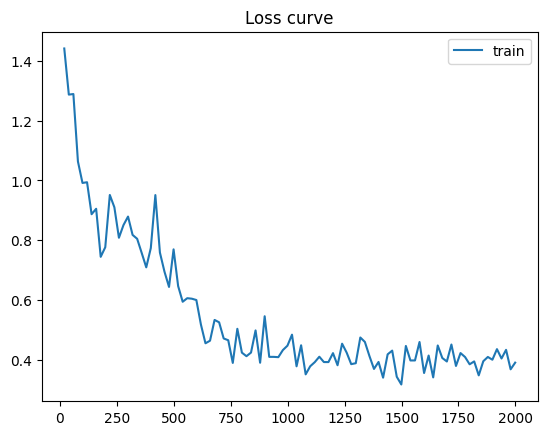

In [30]:
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["total_loss"].isna()]
ax.plot(mdf1["iteration"], mdf1["total_loss"], c="C0", label="train")
if "validation_loss" in mdf.columns:
    mdf2 = mdf[~mdf["validation_loss"].isna()]
    ax.plot(mdf2["iteration"], mdf2["validation_loss"], c="C1", label="validation")

# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Loss curve")
plt.show()

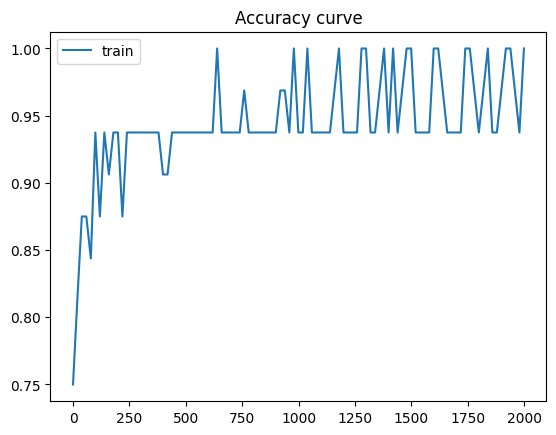

In [31]:
fig, ax = plt.subplots()

mdf1 = mdf[~mdf["fast_rcnn/cls_accuracy"].isna()]
ax.plot(mdf1["iteration"], mdf1["fast_rcnn/cls_accuracy"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("Accuracy curve")
plt.show()

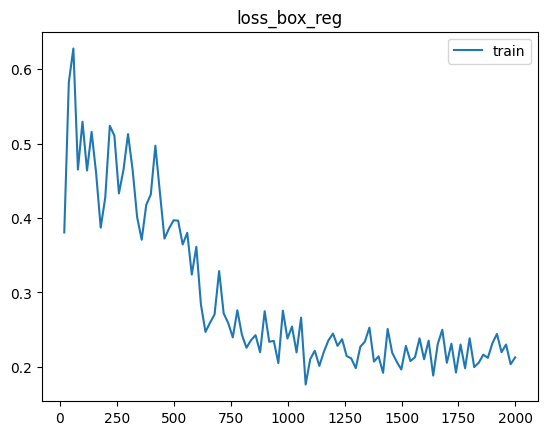

In [32]:
fig, ax = plt.subplots()
mdf1 = mdf[~mdf["loss_box_reg"].isna()]
ax.plot(mdf1["iteration"], mdf1["loss_box_reg"], c="C0", label="train")
# ax.set_ylim([0, 0.5])
ax.legend()
ax.set_title("loss_box_reg")
plt.show()

In [36]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"


In [37]:
!pip install layoutparser
import layoutparser as lp

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 19.2/19.2 MB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 109.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 112.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.6/143.6 kB 19.1 MB/s eta 0:00:00
  Attempting uninstall: pillow
    Found existing installation: Pillow 8.4.0
    Uninstalling Pillow-8.4.0:
      Successfully uninstalled Pillow-8.4.0


config.yml?dl=1: 8.19kB [00:01, 4.19kB/s]


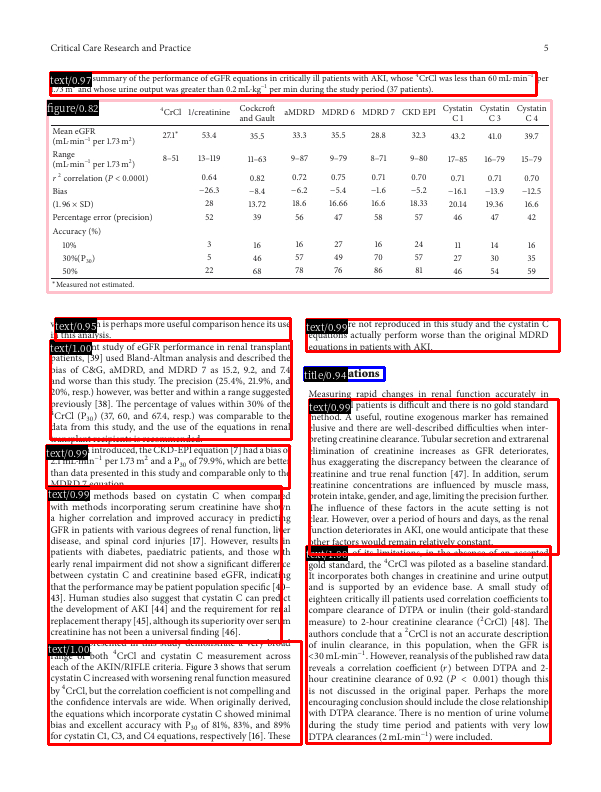

In [38]:
model = lp.Detectron2LayoutModel('lp://PubLayNet/faster_rcnn_R_50_FPN_3x/config',
                                 '/content/output/model_final.pth',
                                 extra_config=["MODEL.ROI_HEADS.SCORE_THRESH_TEST", 0.8],
                                 label_map={0:"None",1: "text", 2: "title", 3: "list", 4:"table", 5:"figure"})
#######################################################
image = cv2.imread('/content/examples/PMC3576793_00004.jpg')

color_map = {
    'text':   'red',
    'title':  'blue',
    'list':   'green',
    'table':  'yellow',
    'figure': 'pink',
}

layout_predicted = model.detect(image)
lp.draw_box(image,
              [b.set(id=f'{b.type}/{b.score:.2f}') for b in layout_predicted],
              color_map=color_map,
              show_element_id=True, id_font_size=10,
              id_text_background_color='black',
              id_text_color='white')

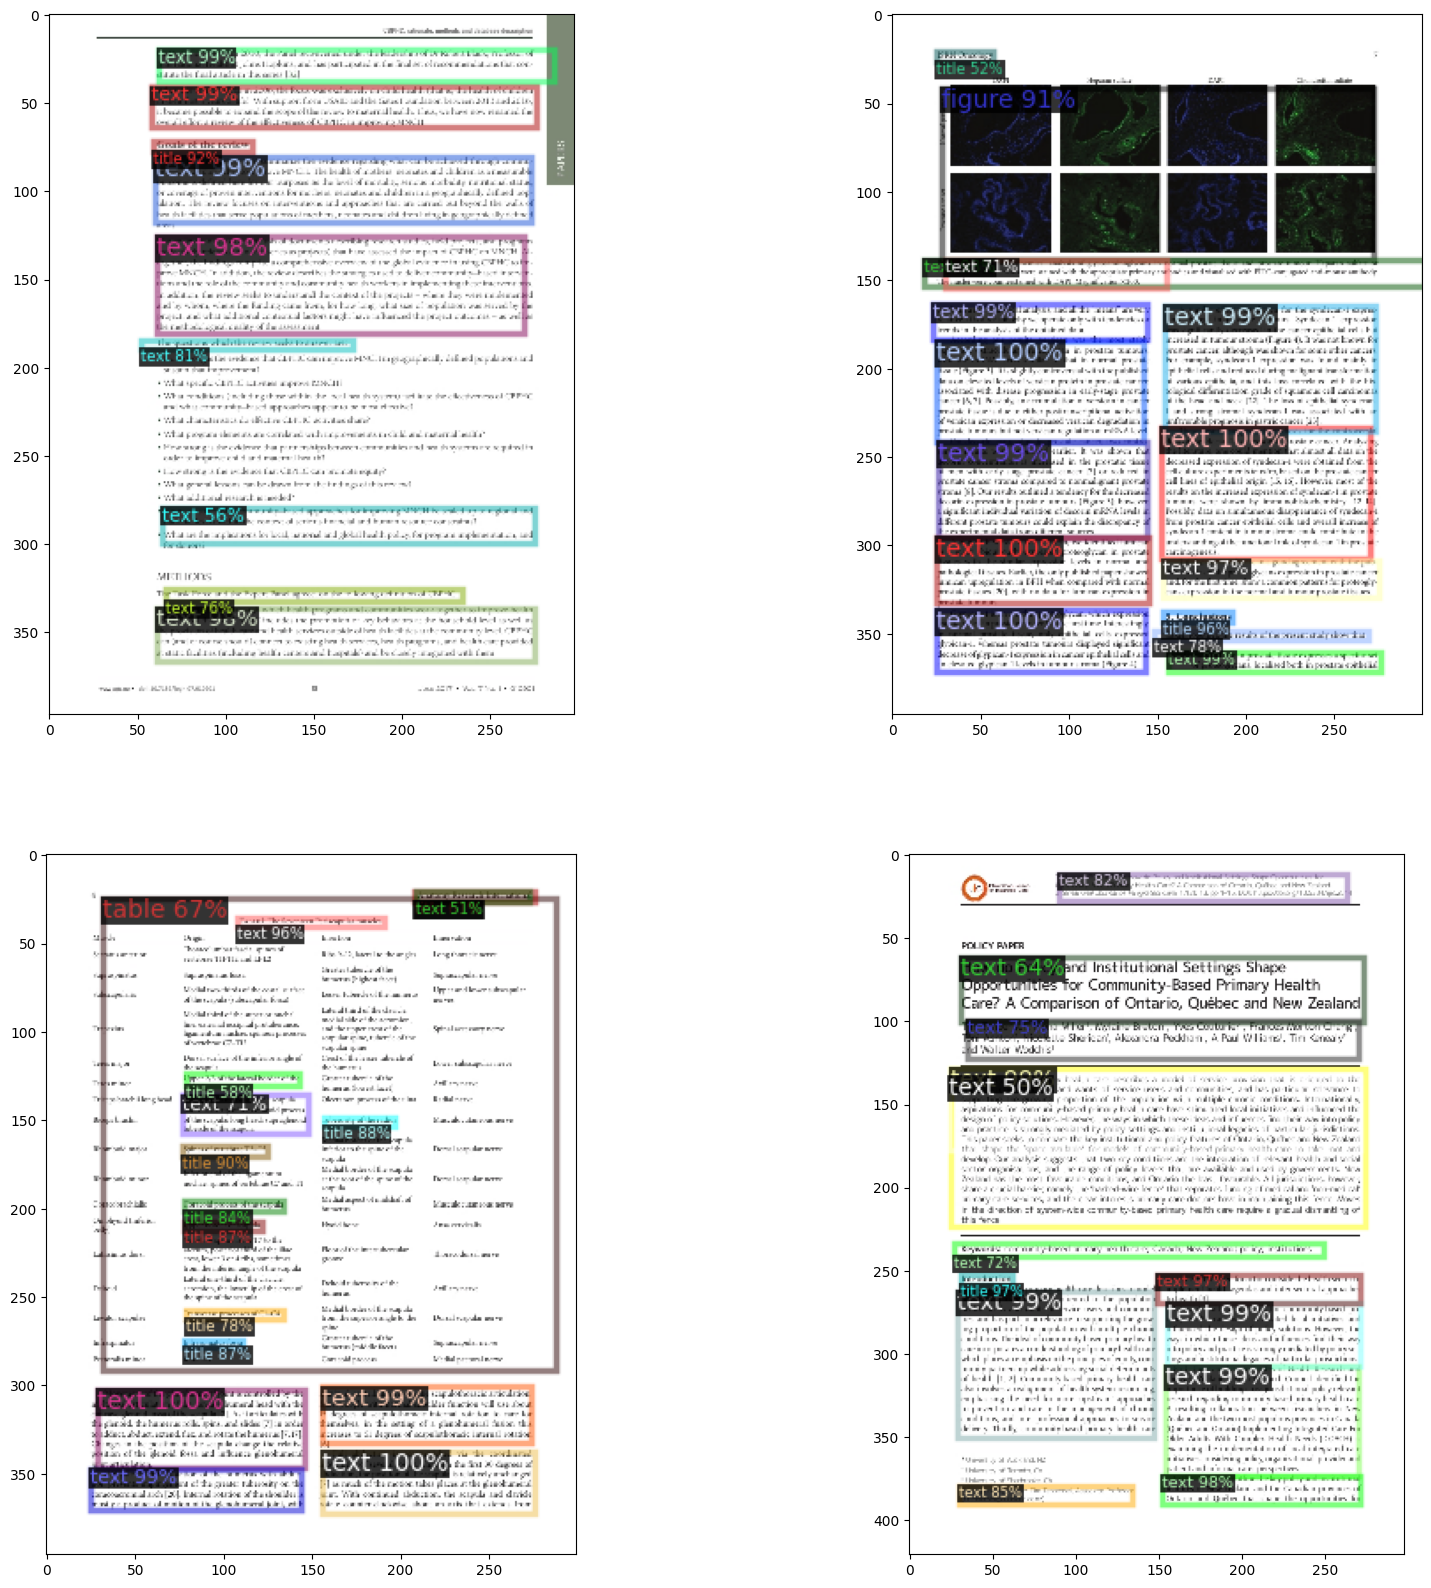

In [39]:
cfg.MODEL.WEIGHTS = "./output/model_final.pth"
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set a custom testing threshold for this model
# cfg.DATASETS.TEST = ("Data_Resister_training", )
predictor = DefaultPredictor(cfg)

###############################################################

fig, ax = plt.subplots(2, 2, figsize =(20,20))
indices=[ax[0][0],ax[1][0],ax[0][1],ax[1][1] ]
i=-1
# Show some qualitative results by predicting on test set images
NUM_TEST_SAMPLES = 4
samples = random.sample(dataset_dicts_train, NUM_TEST_SAMPLES)
for i, sample in enumerate(samples):
    img = cv2.imread(sample["file_name"])
    outputs = predictor(img)
    visualizer = Visualizer(img, metadata=metadata_dicts_train,scale=0.5,)
    visualizer = visualizer.draw_instance_predictions(
        outputs["instances"].to("cpu"))
    display_img = visualizer.get_image()[:, :, ::-1]
    indices[i].grid(False)
    indices[i].imshow(display_img)

### References
* https://layout-parser.readthedocs.io/en/latest/notes/installation.html
* https://github.com/Layout-Parser/layout-model-training/blob/master/tools/train_net.py
* https://towardsdatascience.com/auto-parse-and-understand-any-document-5d72e81b0be9
* https://layout-parser.readthedocs.io/en/latest/api_doc/models.html